In [20]:
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint, uniform
import seaborn as sns
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Preparando DataFrame

In [10]:
steg = pd.read_csv('C:/Users/Lenovo/Desktop/Projetos/TCC_dataset/flowers recognition/flowers_flat/STEG/data.CSV')
non_steg = pd.read_csv('C:/Users/Lenovo/Desktop/Projetos/TCC_dataset/flowers recognition/flowers_flat/data.CSV')

steg

,Tamanho,Qui Quadrado,RS Total,RS Rm,RS Sm,RS R-m,RS R-s,RS Rm (1 - p/2),RS Sm (1 - p/2),RS R-m (1 - p/2),RS R-s (1 - p/2),RS x,RS p,Media,Variancia,curtose,obliquidade
0,253440,78523.495567,84480,66730,6401,72966,4153,62750,7957,76797,2448,-0.034051,0.063760,0.137989,0.118949,277.202477,-4.333423
1,207360,71355.666247,69120,56565,4584,59071,3598,52664,5938,62899,2171,-0.016535,0.032011,0.122748,0.107681,203.907631,-12.826958
2,508032,116818.032679,169344,113882,20988,115096,20163,95504,28906,133508,12279,-0.005462,0.010806,0.243784,0.184354,134.826462,-7.920534
3,132480,44277.776545,44160,35514,3201,36807,2472,32698,3955,39480,1575,-0.015419,0.029916,0.133379,0.115590,207.658234,-10.623822
4,207360,53862.929108,69120,50922,6771,59057,3334,47792,7383,62023,2558,-0.061861,0.110099,0.171465,0.142065,219.840720,-5.123195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4308,508032,203693.715692,169344,151445,6961,155011,5458,146027,8857,160252,3385,-0.008697,0.017097,0.077470,0.071468,200.061447,-14.032725
4309,230400,52447.487402,76800,52581,9983,53217,9016,44755,13287,61102,5771,-0.009332,0.018322,0.235803,0.180201,161.146070,-7.028610
4310,230400,45793.720264,76800,49402,10910,50232,10179,40943,14774,58856,6480,-0.010054,0.019711,0.266072,0.195279,118.356528,-6.701141
4311,230400,65887.660742,76800,57520,7480,58480,6740,50235,10187,65547,3815,-0.008429,0.016579,0.185074,0.150822,166.514632,-11.933194


In [11]:
steg.columns = [x.strip() for x in steg.columns]
non_steg.columns = [x.strip() for x in steg.columns]

In [12]:
def normalize_df(df, is_steg):
    df = df.copy()
    df['is_steg'] = is_steg
    df['norm RS Rm'] = df['RS Rm']/df['RS Total']
    df['norm RS Sm'] = df['RS Sm']/df['RS Total']
    df['norm RS R-m'] = df['RS R-m']/df['RS Total']
    df['norm RS R-s'] = df['RS R-s']/df['RS Total']
    df['norm RS Rm (1 - p/2)'] = df['RS Rm (1 - p/2)']/df['RS Total']
    df['norm RS Sm (1 - p/2)'] = df['RS Sm (1 - p/2)']/df['RS Total']
    df['norm RS R-m (1 - p/2)'] = df['RS R-m (1 - p/2)']/df['RS Total']
    df['norm RS R-s (1 - p/2)'] = df['RS R-s (1 - p/2)']/df['RS Total']

    return df

norm_steg = normalize_df(steg, True)
norm_non_steg = normalize_df(non_steg, False)

df = pd.concat([norm_steg, norm_non_steg]).reset_index(drop=True)

df

,Tamanho,Qui Quadrado,RS Total,RS Rm,RS Sm,RS R-m,RS R-s,RS Rm (1 - p/2),RS Sm (1 - p/2),RS R-m (1 - p/2),...,obliquidade,is_steg,norm RS Rm,norm RS Sm,norm RS R-m,norm RS R-s,norm RS Rm (1 - p/2),norm RS Sm (1 - p/2),norm RS R-m (1 - p/2),norm RS R-s (1 - p/2)
0,253440,78523.495567,84480,66730,6401,72966,4153,62750,7957,76797,...,-4.333423,True,0.789891,0.075769,0.863707,0.049160,0.742779,0.094188,0.909055,0.028977
1,207360,71355.666247,69120,56565,4584,59071,3598,52664,5938,62899,...,-12.826958,True,0.818359,0.066319,0.854615,0.052054,0.761921,0.085909,0.909997,0.031409
2,508032,116818.032679,169344,113882,20988,115096,20163,95504,28906,133508,...,-7.920534,True,0.672489,0.123937,0.679658,0.119065,0.563964,0.170694,0.788383,0.072509
3,132480,44277.776545,44160,35514,3201,36807,2472,32698,3955,39480,...,-10.623822,True,0.804212,0.072486,0.833492,0.055978,0.740444,0.089561,0.894022,0.035666
4,207360,53862.929108,69120,50922,6771,59057,3334,47792,7383,62023,...,-5.123195,True,0.736719,0.097960,0.854413,0.048235,0.691435,0.106814,0.897323,0.037008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621,508032,217236.303534,169344,155480,5575,154624,5613,149327,7820,160639,...,-14.032620,False,0.918131,0.032921,0.913076,0.033146,0.881797,0.046178,0.948596,0.019074
8622,230400,54111.850785,76800,53287,9510,52602,9457,44193,13658,61717,...,-7.028810,False,0.693841,0.123828,0.684922,0.123138,0.575430,0.177839,0.803607,0.069401
8623,230400,47747.993425,76800,50107,10463,49702,10512,40631,15036,59386,...,-6.696721,False,0.652435,0.136237,0.647161,0.136875,0.529049,0.195781,0.773255,0.080039
8624,230400,68064.272138,76800,58214,7128,58131,6939,50243,10245,65896,...,-11.933048,False,0.757995,0.092813,0.756914,0.090352,0.654206,0.133398,0.858021,0.047083


In [13]:
df.columns

Index(['Tamanho', 'Qui Quadrado', 'RS Total', 'RS Rm', 'RS Sm', 'RS R-m',
       'RS R-s', 'RS Rm (1 - p/2)', 'RS Sm (1 - p/2)', 'RS R-m (1 - p/2)',
       'RS R-s (1 - p/2)', 'RS x', 'RS p', 'Media', 'Variancia', 'curtose',
       'obliquidade', 'is_steg', 'norm RS Rm', 'norm RS Sm', 'norm RS R-m',
       'norm RS R-s', 'norm RS Rm (1 - p/2)', 'norm RS Sm (1 - p/2)',
       'norm RS R-m (1 - p/2)', 'norm RS R-s (1 - p/2)'],
      dtype='object')

# Exploração dos dados

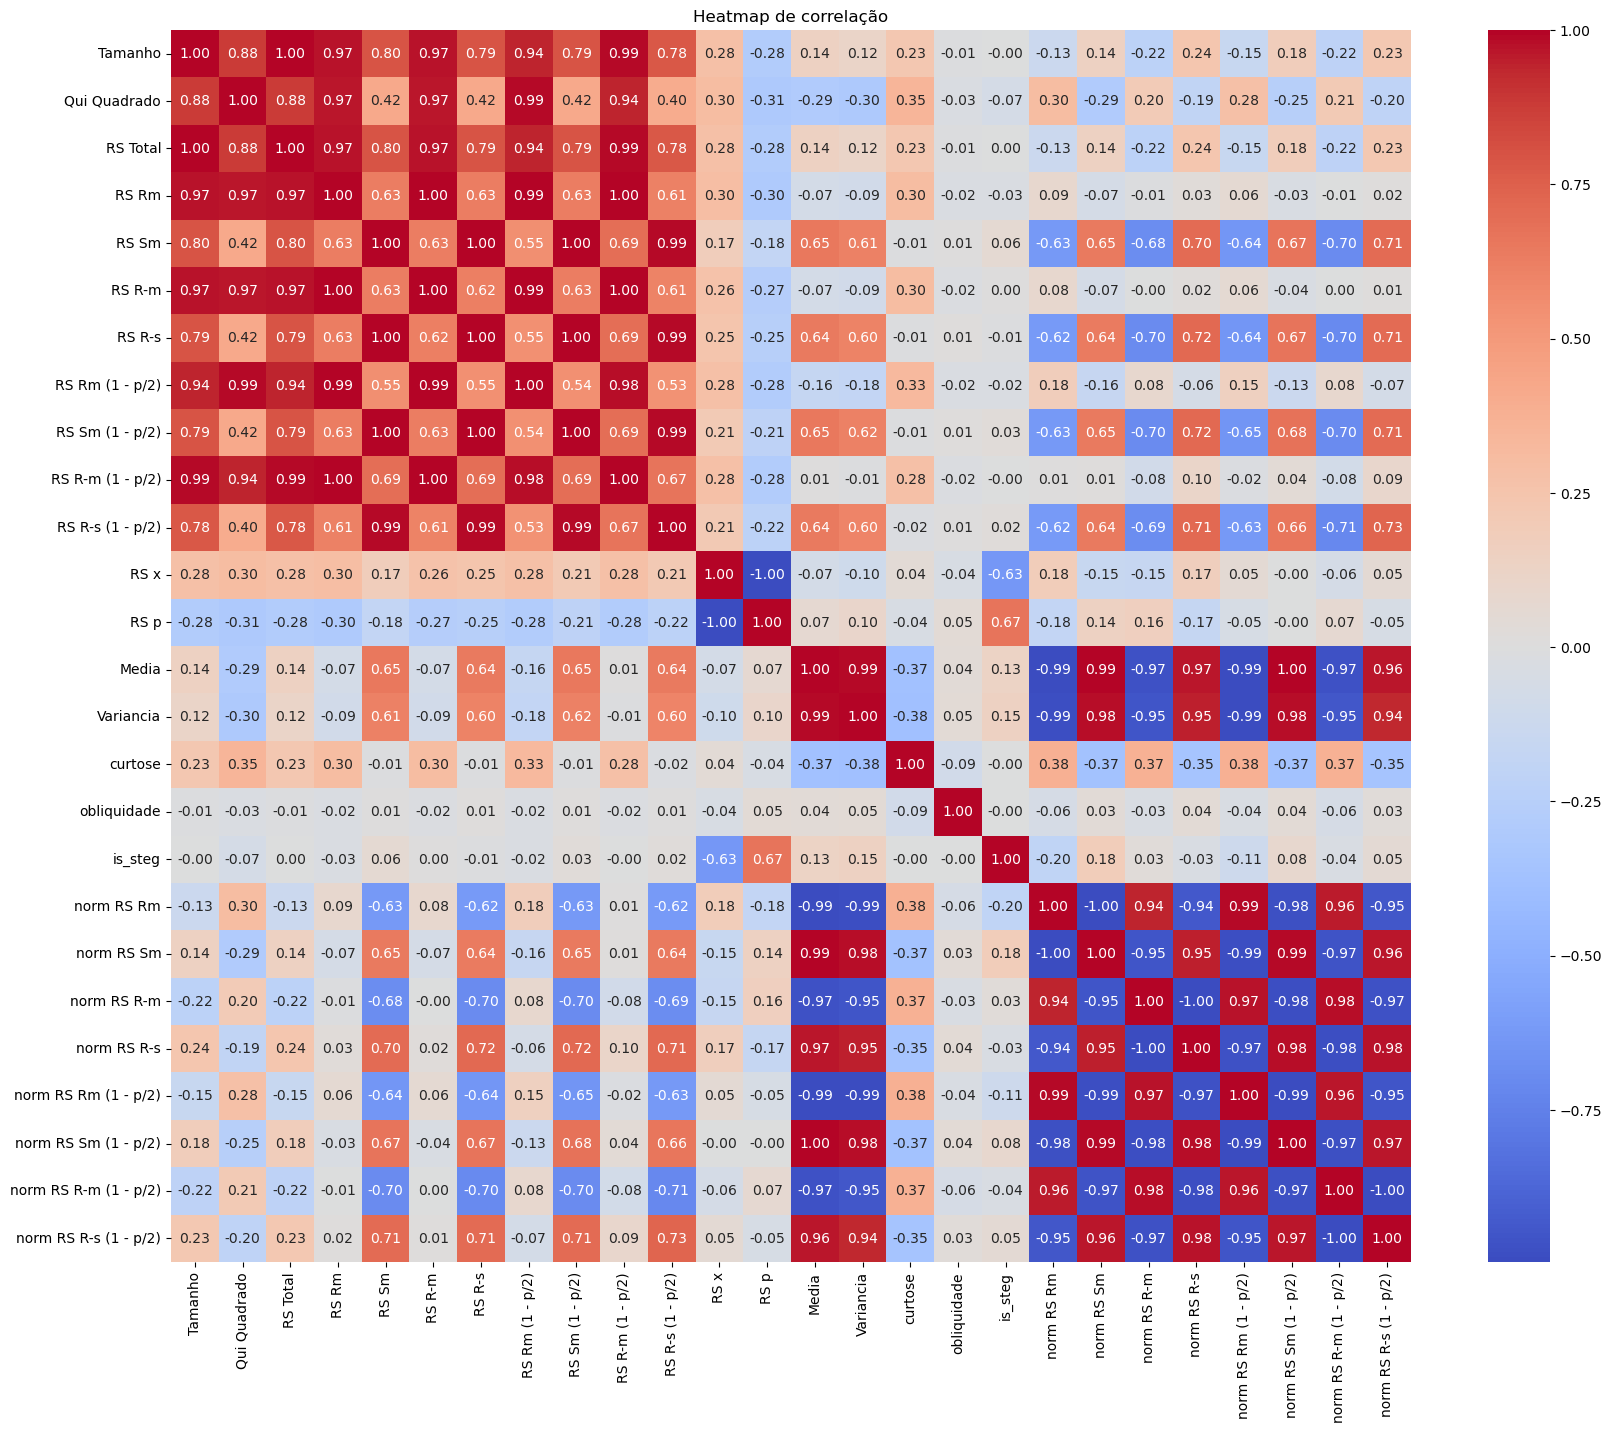

In [14]:
corr_matrix = df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap de correlação')
plt.show()

In [15]:
print("\nCorrelações com 'is_steg':")
print(corr_matrix['is_steg'].sort_values(ascending=False))


Correlações com 'is_steg':
is_steg                  1.000000e+00
RS p                     6.707001e-01
norm RS Sm               1.816323e-01
Variancia                1.466003e-01
Media                    1.267037e-01
norm RS Sm (1 - p/2)     8.172427e-02
RS Sm                    6.219908e-02
norm RS R-s (1 - p/2)    5.130817e-02
RS Sm (1 - p/2)          2.836103e-02
norm RS R-m              2.549739e-02
RS R-s (1 - p/2)         1.757983e-02
RS R-m                   3.492900e-03
RS Total                 1.079042e-15
Tamanho                 -5.774521e-16
curtose                 -4.723605e-04
obliquidade             -8.301556e-04
RS R-m (1 - p/2)        -3.170264e-03
RS R-s                  -1.077168e-02
RS Rm (1 - p/2)         -2.220550e-02
RS Rm                   -2.696580e-02
norm RS R-s             -3.129422e-02
norm RS R-m (1 - p/2)   -3.696363e-02
Qui Quadrado            -6.776931e-02
norm RS Rm (1 - p/2)    -1.149233e-01
norm RS Rm              -1.995193e-01
RS x                  

# Preparação de dados, treinamento dos modelos e otimização de hiperparâmetros

In [17]:
X = df.drop('is_steg', axis=1)
y = df['is_steg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
def evaluate_model(model, X_train_use, y_train, X_test_use, X, params=None):
    
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='f1')
    
    y_pred = model.predict(X_test_use)
    y_prob = model.predict_proba(X_test_use)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()
        
        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_prob)
        plt.figure()
        plt.plot(recall_pr, precision_pr, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {name}')
        plt.legend()
        plt.show()
    
    print(f"\nExplicando {name} com SHAP...")
    try:
        if name in ['GradientBoostingClassifier', 'XGBClassifier', 'LGBMClassifier']:
            explainer = shap.Explainer(model, check_additivity=False)
        elif name in ['SVC'] and model.kernel != 'linear':
            # KernelExplainer para SVM não linear
            background = shap.kmeans(X_train_use, 50).data 
            explainer = shap.KernelExplainer(model.predict_proba, background)
        elif name in ['LogisticRegression', 'KNeighborsClassifier', 'AdaBoostClassifier', 'SVC']:
            # KernelExplainer para modelos lineares
            background = shap.kmeans(X_train_use, 50).data
            explainer = shap.KernelExplainer(model.predict_proba, background)
        else:
            explainer = shap.Explainer(model, X_train_use)
        
        shap_values = explainer(X_test_use)
        
        if len(shap_values.shape) == 2:  
            shap.summary_plot(shap_values, X_test_use, feature_names=X.columns)
            importances = np.abs(shap_values.values).mean(0)
        else:
            shap.summary_plot(shap_values[:, :, 1], X_test_use, feature_names=X.columns) 
            importances = np.abs(shap_values[:, :, 1].values).mean(0)
        
        feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
        print(f"\nFeature Importances for {name} (SHAP):")
        print(feature_importance)
        
        if hasattr(model, 'feature_importances_'):
            built_in_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
            print(f"\nBuilt-in Feature Importances for {name}:")
            print(built_in_importance)
    except Exception as e:
        print(f"SHAP explanation failed for {name}: {str(e)}")
    
    # Avaliação detalhada
    print(f"\nAvaliação Detalhada para {name}:")
    if params != None:
        print(f"Melhores Parâmetros: {params}")
    print(f"Cross-Val F1 Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Acurácia de Teste: {accuracy:.4f}")
    print(f"Precisão de Teste: {precision:.4f}")
    print(f"Revocação de Teste: {recall:.4f}")
    print(f"F1 de Teste: {f1:.4f}")
    if roc_auc:
        print(f"Área sob a curva ROC de Teste: {roc_auc:.4f}")
    print("\nMatriz de confusão:")
    print(conf_matrix)
    print("\nRelatório de Classificação:")
    print(class_report)

In [19]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': uniform(0.01, 10),
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': randint(3, 20),
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': uniform(0.1, 10),
            'kernel': ['rbf', 'linear'],
            'gamma': uniform(0.001, 1)
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': randint(3, 20),
            'min_samples_split': randint(2, 10),
            'min_samples_leaf': randint(1, 5)
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': randint(50, 200),
            'max_depth': randint(5, 20),
            'min_samples_split': randint(2, 10),
            'min_samples_leaf': randint(1, 5)
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': randint(50, 200),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 10)
        }
    },
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': randint(50, 200),
            'learning_rate': uniform(0.01, 0.3)
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': randint(50, 200),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 10),
            'subsample': uniform(0.6, 0.4)
        }
    },
    'LGBMClassifier': {
        'model': LGBMClassifier(),
        'params': {
            'n_estimators': randint(50, 200),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 10),
            'num_leaves': randint(20, 50)
        }
    },
    'MLPClassifier': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd'],
            'alpha': uniform(0.0001, 0.01),
            'learning_rate': ['constant', 'adaptive']
        }
    }
}


Training LogisticRegression...


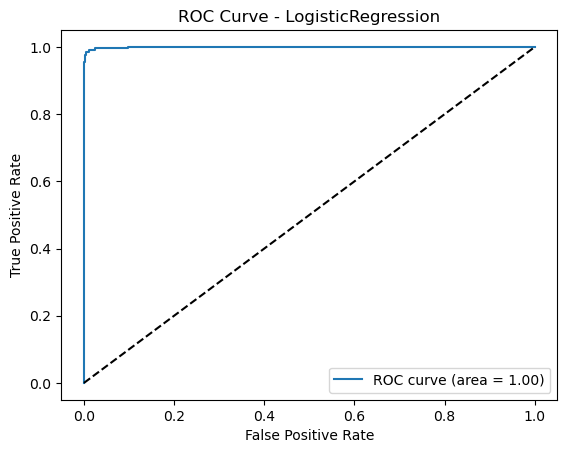

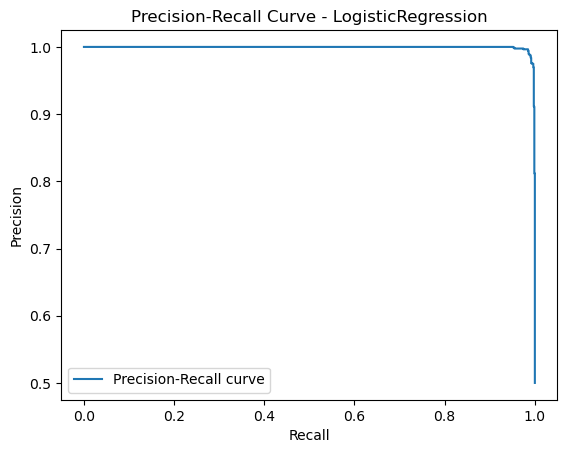


Explicando LogisticRegression com SHAP...


  0%|          | 0/1726 [00:00<?, ?it/s]

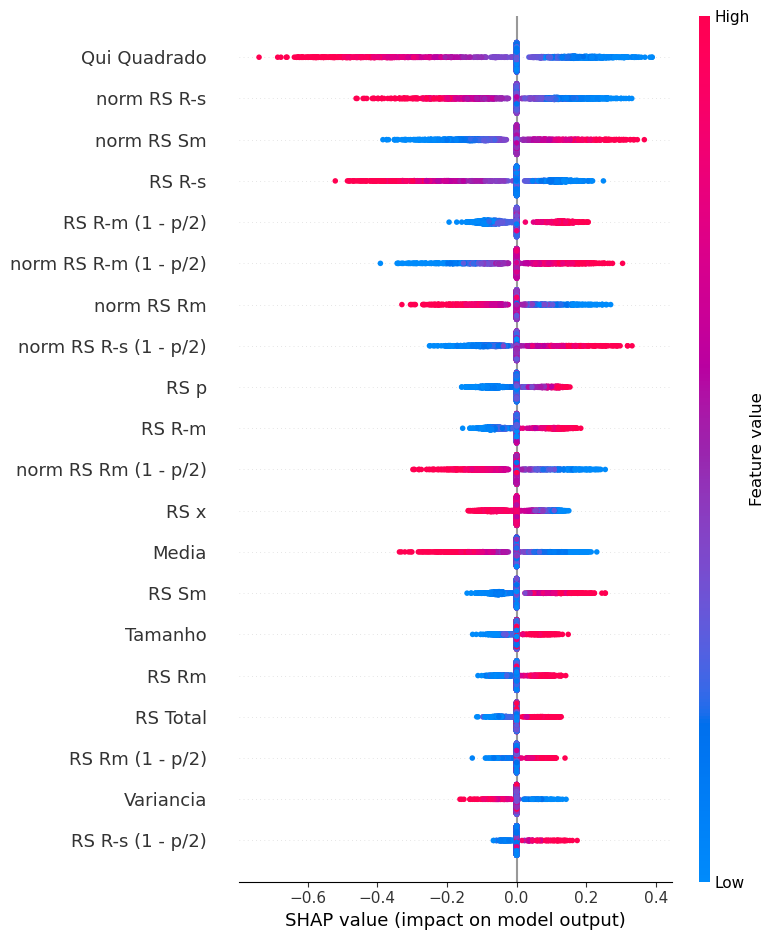


Feature Importances for LogisticRegression (SHAP):
Qui Quadrado             0.166019
norm RS R-s              0.102285
norm RS Sm               0.093558
RS R-s                   0.091993
RS R-m (1 - p/2)         0.071676
norm RS R-m (1 - p/2)    0.067393
norm RS Rm               0.060030
norm RS R-s (1 - p/2)    0.058921
RS p                     0.056665
RS R-m                   0.055748
norm RS Rm (1 - p/2)     0.053962
RS x                     0.048607
Media                    0.044826
RS Sm                    0.042575
Tamanho                  0.022445
RS Rm                    0.021804
RS Total                 0.021742
RS Rm (1 - p/2)          0.012511
Variancia                0.006796
RS R-s (1 - p/2)         0.006428
RS Sm (1 - p/2)          0.004671
norm RS Sm (1 - p/2)     0.000551
norm RS R-m              0.000095
curtose                  0.000000
obliquidade              0.000000
dtype: float64

Avaliação Detalhada para LogisticRegression:
Melhores Parâmetros: {'C': 9.74755518

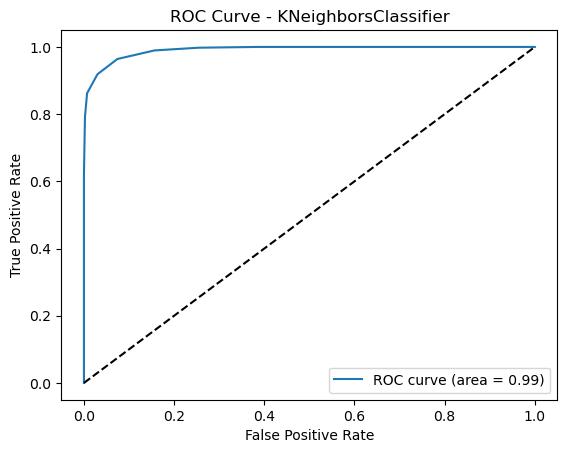

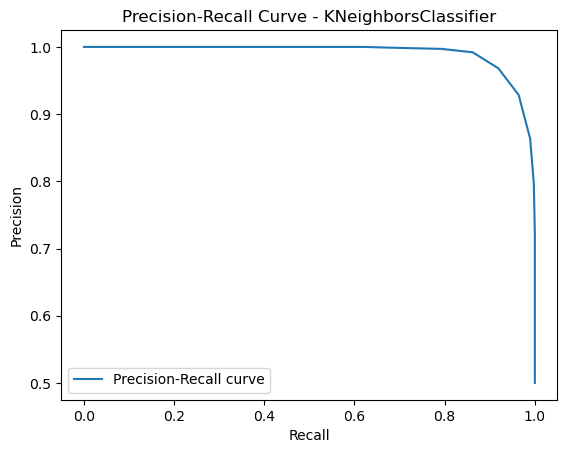


Explicando KNeighborsClassifier com SHAP...


  0%|          | 0/1726 [00:00<?, ?it/s]

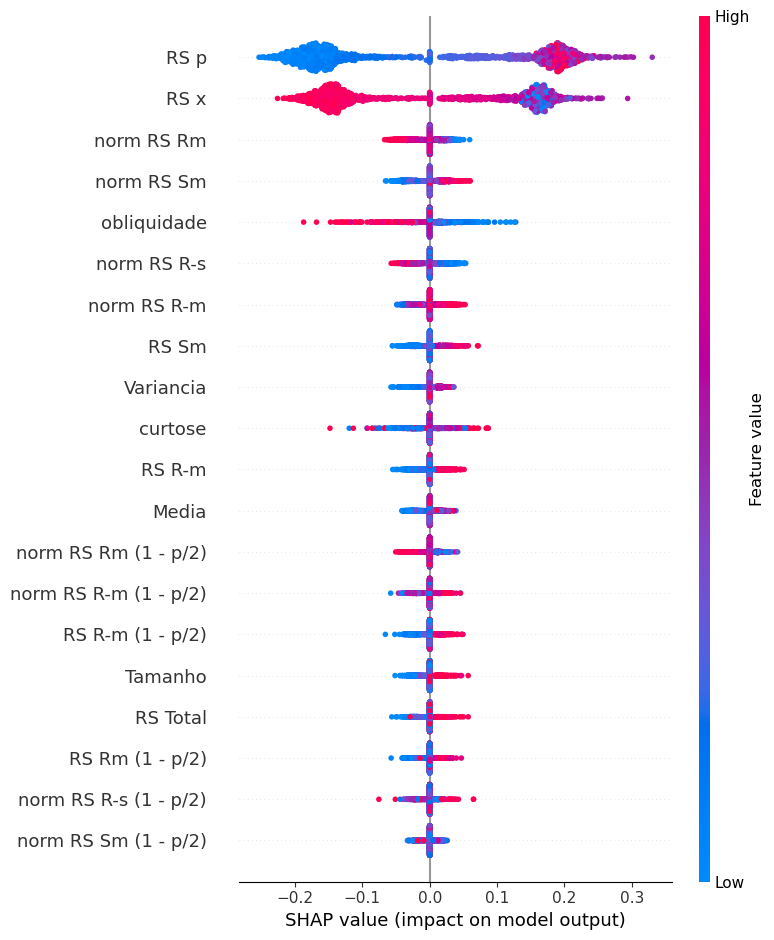


Feature Importances for KNeighborsClassifier (SHAP):
RS p                     0.162747
RS x                     0.140221
norm RS Rm               0.018743
norm RS Sm               0.017670
obliquidade              0.014295
norm RS R-s              0.013882
norm RS R-m              0.012399
RS Sm                    0.011045
Variancia                0.009198
curtose                  0.008031
RS R-m                   0.007852
Media                    0.007271
norm RS Rm (1 - p/2)     0.006975
norm RS R-m (1 - p/2)    0.005921
RS R-m (1 - p/2)         0.005873
Tamanho                  0.005231
RS Total                 0.005115
RS Rm (1 - p/2)          0.004397
norm RS R-s (1 - p/2)    0.004183
norm RS Sm (1 - p/2)     0.003598
Qui Quadrado             0.003578
RS R-s (1 - p/2)         0.003397
RS Rm                    0.003245
RS R-s                   0.003021
RS Sm (1 - p/2)          0.002464
dtype: float64

Avaliação Detalhada para KNeighborsClassifier:
Melhores Parâmetros: {'n_neighbor

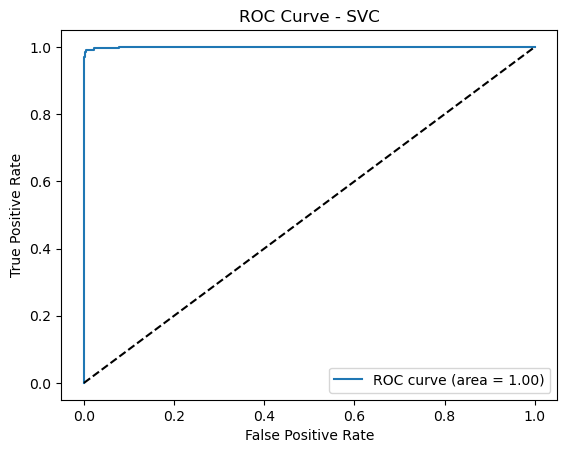

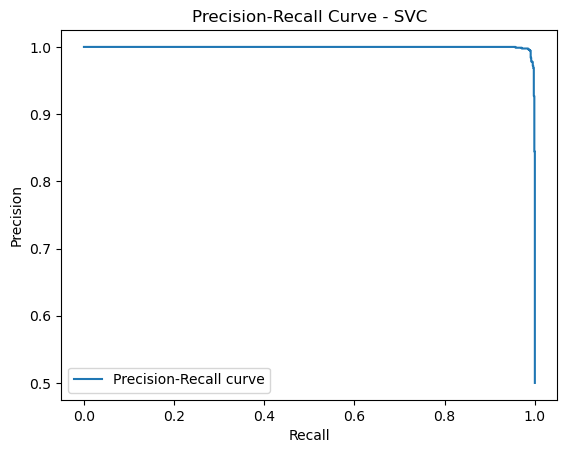


Explicando SVC com SHAP...


  0%|          | 0/1726 [00:00<?, ?it/s]

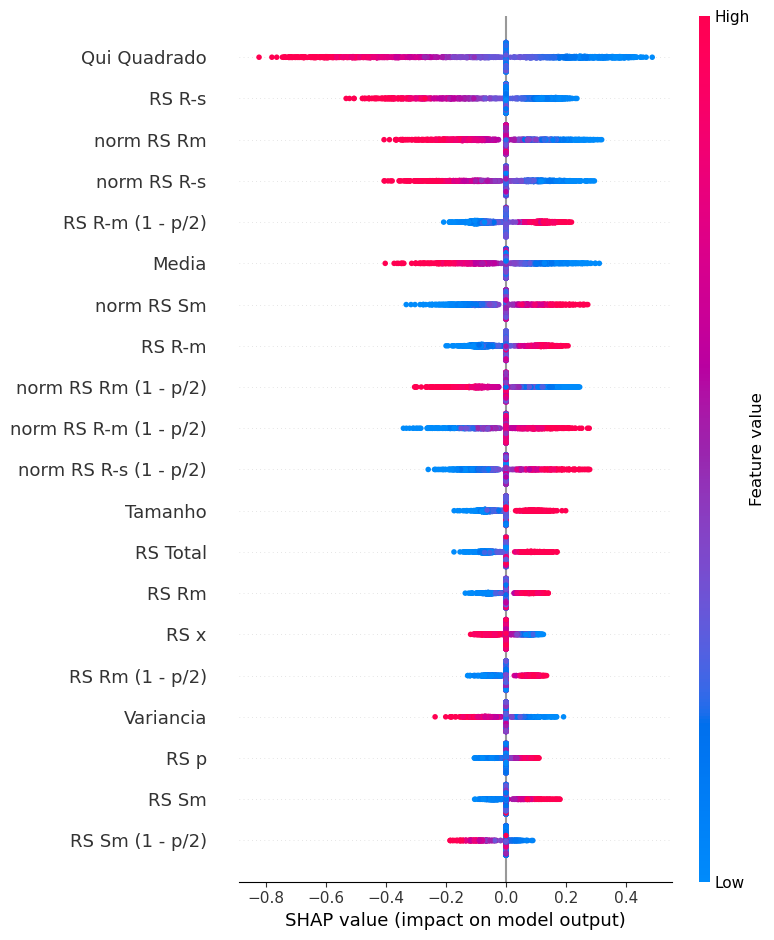


Feature Importances for SVC (SHAP):
Qui Quadrado             0.216094
RS R-s                   0.100162
norm RS Rm               0.090596
norm RS R-s              0.080621
RS R-m (1 - p/2)         0.072592
Media                    0.067233
norm RS Sm               0.063797
RS R-m                   0.063312
norm RS Rm (1 - p/2)     0.057060
norm RS R-m (1 - p/2)    0.054678
norm RS R-s (1 - p/2)    0.052967
Tamanho                  0.043224
RS Total                 0.042889
RS Rm                    0.027931
RS x                     0.024584
RS Rm (1 - p/2)          0.023578
Variancia                0.021159
RS p                     0.018755
RS Sm                    0.014862
RS Sm (1 - p/2)          0.010380
norm RS Sm (1 - p/2)     0.009699
RS R-s (1 - p/2)         0.005611
norm RS R-m              0.000462
curtose                  0.000000
obliquidade              0.000000
dtype: float64

Avaliação Detalhada para SVC:
Melhores Parâmetros: {'C': 9.485527090157502, 'gamma': 0.0017787658

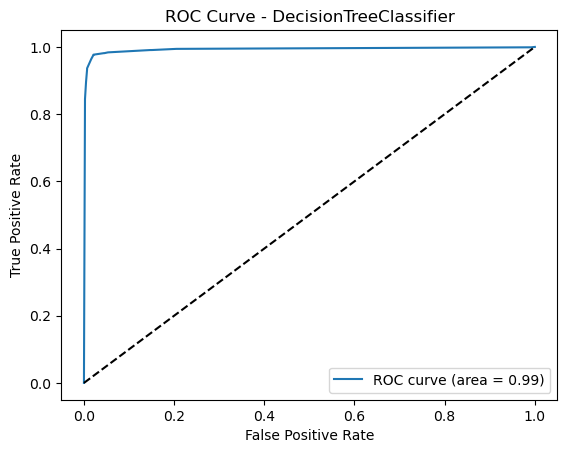

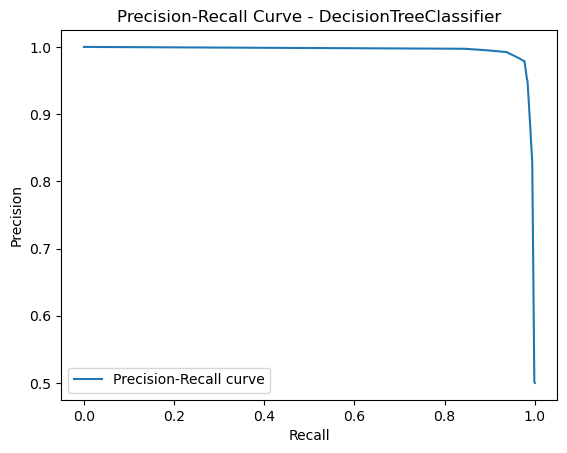


Explicando DecisionTreeClassifier com SHAP...


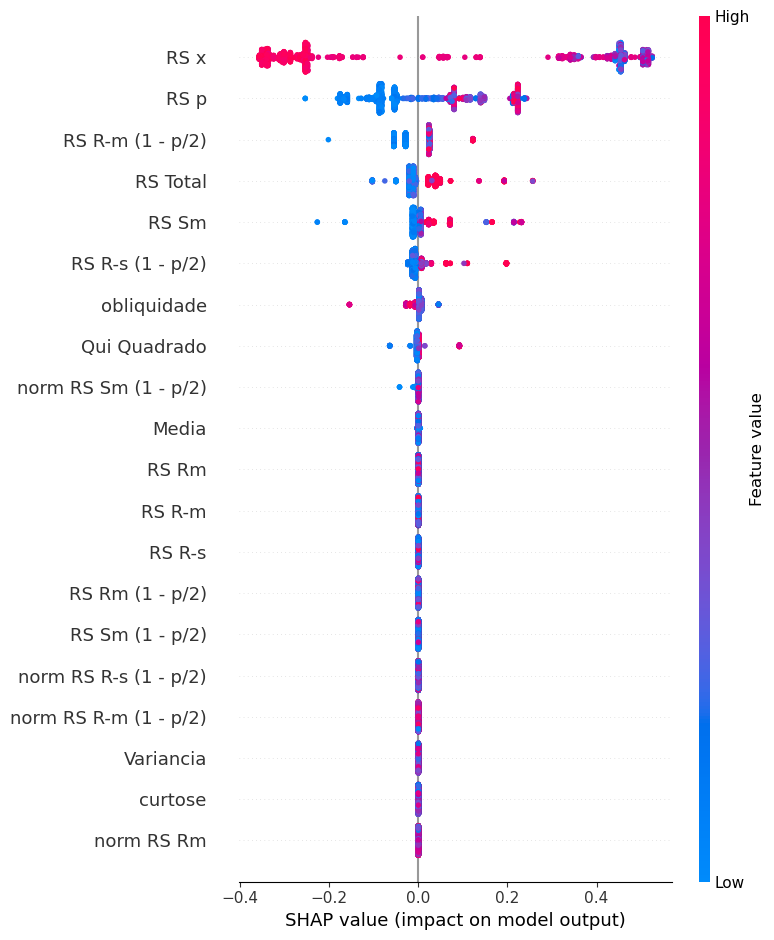


Feature Importances for DecisionTreeClassifier (SHAP):
RS x                     0.357092
RS p                     0.115604
RS R-m (1 - p/2)         0.033085
RS Total                 0.026914
RS Sm                    0.018299
RS R-s (1 - p/2)         0.012846
obliquidade              0.006924
Qui Quadrado             0.004562
norm RS Sm (1 - p/2)     0.000535
Media                    0.000069
norm RS R-m (1 - p/2)    0.000000
norm RS Rm (1 - p/2)     0.000000
norm RS R-s              0.000000
norm RS R-m              0.000000
norm RS Sm               0.000000
norm RS Rm               0.000000
Tamanho                  0.000000
curtose                  0.000000
Variancia                0.000000
RS Sm (1 - p/2)          0.000000
RS Rm (1 - p/2)          0.000000
RS R-s                   0.000000
RS R-m                   0.000000
RS Rm                    0.000000
norm RS R-s (1 - p/2)    0.000000
dtype: float64

Built-in Feature Importances for DecisionTreeClassifier:
RS x                 

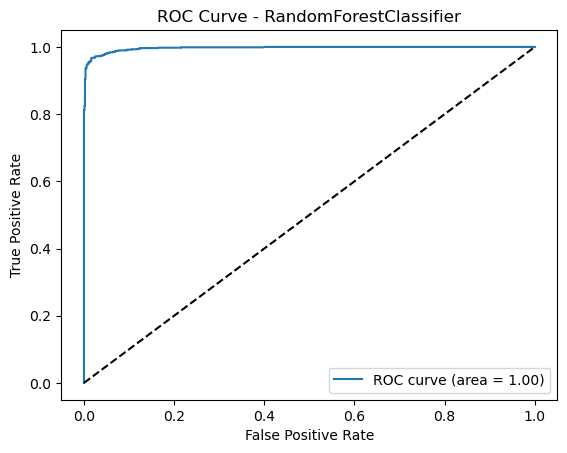

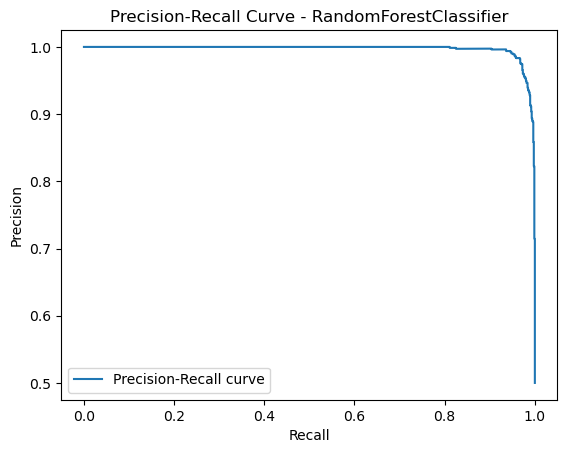


Explicando RandomForestClassifier com SHAP...


 99%|===================| 3412/3452 [00:29<00:00]        

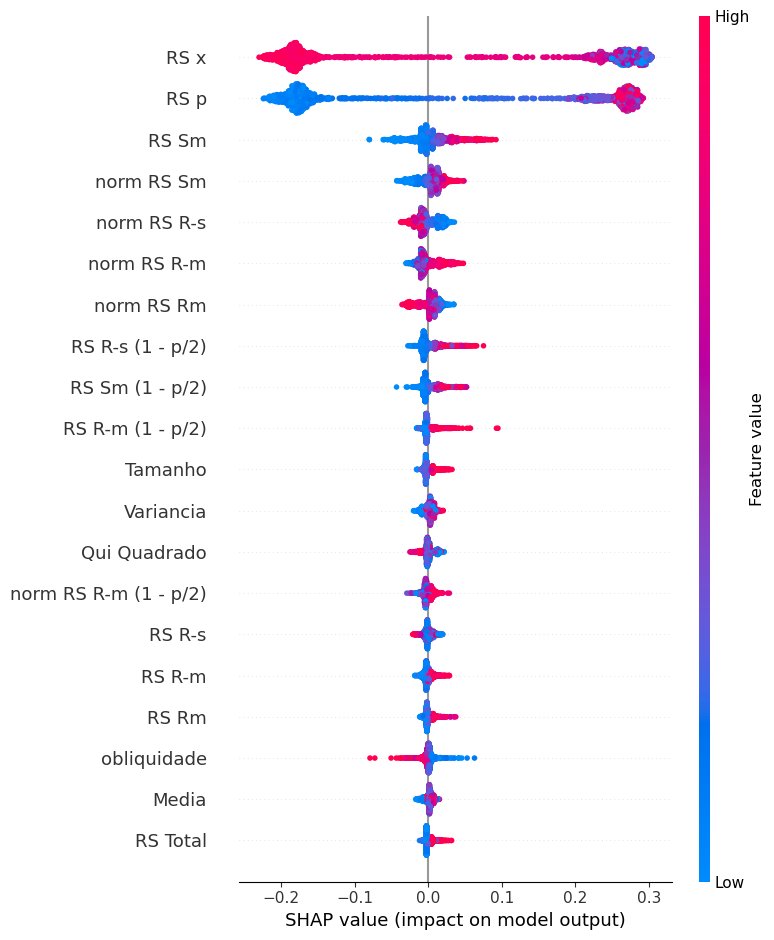


Feature Importances for RandomForestClassifier (SHAP):
RS x                     0.211412
RS p                     0.205550
RS Sm                    0.017550
norm RS Sm               0.012694
norm RS R-s              0.011725
norm RS R-m              0.011363
norm RS Rm               0.010175
RS R-s (1 - p/2)         0.009607
RS Sm (1 - p/2)          0.008836
RS R-m (1 - p/2)         0.005376
Tamanho                  0.005154
Variancia                0.004969
Qui Quadrado             0.004682
norm RS R-m (1 - p/2)    0.004655
RS R-s                   0.004316
RS R-m                   0.004122
RS Rm                    0.003950
obliquidade              0.003919
Media                    0.003764
RS Total                 0.003607
norm RS R-s (1 - p/2)    0.003281
norm RS Sm (1 - p/2)     0.002989
norm RS Rm (1 - p/2)     0.002650
RS Rm (1 - p/2)          0.002326
curtose                  0.001187
dtype: float64

Built-in Feature Importances for RandomForestClassifier:
RS x                 

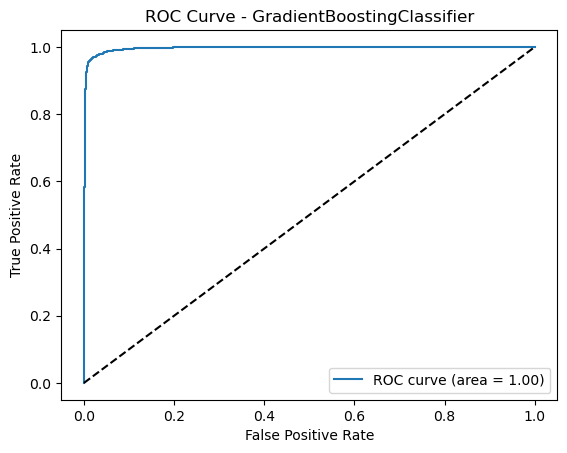

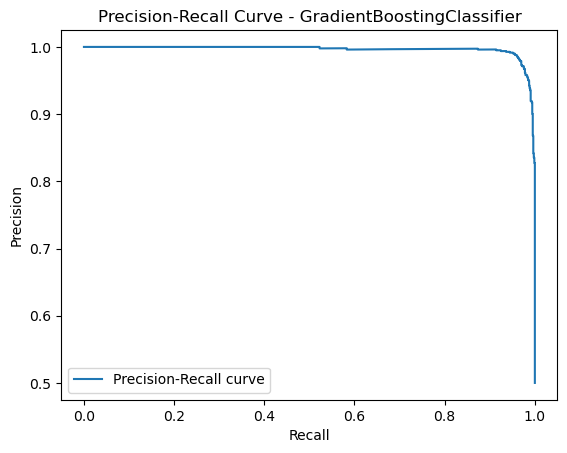


Explicando GradientBoostingClassifier com SHAP...
SHAP explanation failed for GradientBoostingClassifier: TreeExplainer.__init__() got an unexpected keyword argument 'check_additivity'

Avaliação Detalhada para GradientBoostingClassifier:
Melhores Parâmetros: {'learning_rate': 0.2525192044349383, 'max_depth': 3, 'n_estimators': 139}
Cross-Val F1 Mean: 0.9667 ± 0.0061
Acurácia de Teste: 0.9739
Precisão de Teste: 0.9778
Revocação de Teste: 0.9699
F1 de Teste: 0.9738
Área sob a curva ROC de Teste: 0.9964

Matriz de confusão:
[[844  19]
 [ 26 837]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       863
        True       0.98      0.97      0.97       863

    accuracy                           0.97      1726
   macro avg       0.97      0.97      0.97      1726
weighted avg       0.97      0.97      0.97      1726


Training AdaBoostClassifier...


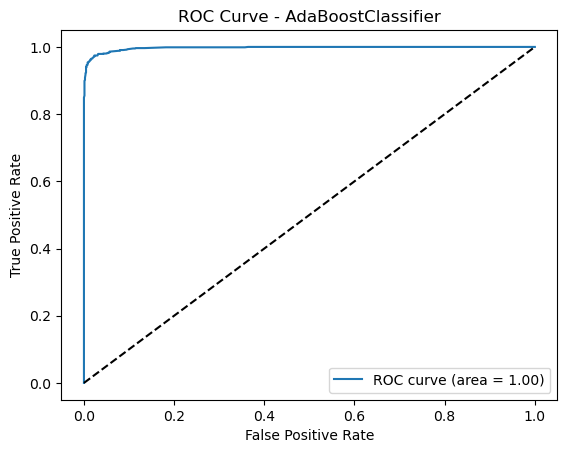

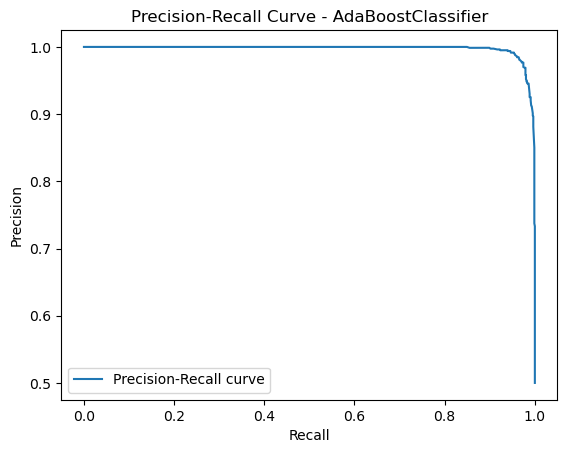


Explicando AdaBoostClassifier com SHAP...


  0%|          | 0/1726 [00:00<?, ?it/s]

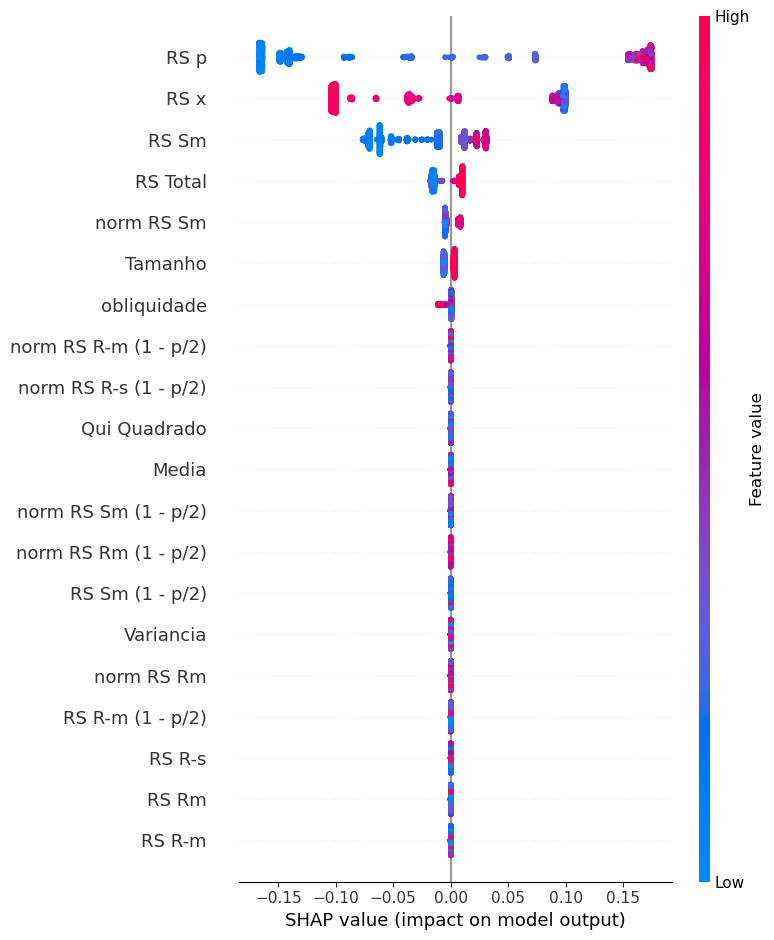


Feature Importances for AdaBoostClassifier (SHAP):
RS p                     0.147988
RS x                     0.086945
RS Sm                    0.039701
RS Total                 0.013364
norm RS Sm               0.005388
Tamanho                  0.005043
obliquidade              0.002143
norm RS R-m (1 - p/2)    0.000015
norm RS R-s (1 - p/2)    0.000015
Qui Quadrado             0.000014
Media                    0.000014
norm RS Sm (1 - p/2)     0.000013
norm RS Rm (1 - p/2)     0.000013
RS Sm (1 - p/2)          0.000013
Variancia                0.000013
norm RS Rm               0.000012
RS R-m (1 - p/2)         0.000012
RS R-s                   0.000012
RS Rm                    0.000012
RS R-m                   0.000012
norm RS R-m              0.000012
RS R-s (1 - p/2)         0.000012
curtose                  0.000012
norm RS R-s              0.000012
RS Rm (1 - p/2)          0.000010
dtype: float64

Built-in Feature Importances for AdaBoostClassifier:
RS p                     0.48

C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [02:17:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [02:17:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [02:17:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [02:17:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\lear

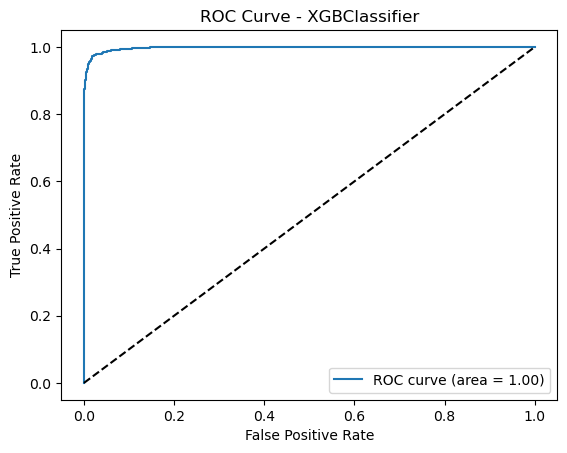

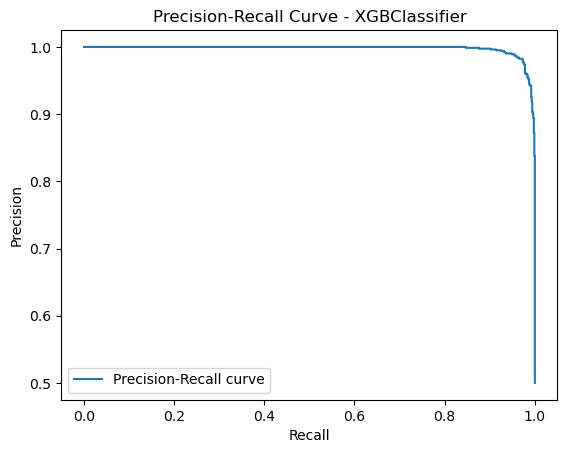


Explicando XGBClassifier com SHAP...
SHAP explanation failed for XGBClassifier: TreeExplainer.__init__() got an unexpected keyword argument 'check_additivity'

Avaliação Detalhada para XGBClassifier:
Melhores Parâmetros: {'learning_rate': 0.19355586841671385, 'max_depth': 4, 'n_estimators': 64, 'subsample': 0.7824279936868144}
Cross-Val F1 Mean: 0.9697 ± 0.0060
Acurácia de Teste: 0.9768
Precisão de Teste: 0.9813
Revocação de Teste: 0.9722
F1 de Teste: 0.9767
Área sob a curva ROC de Teste: 0.9975

Matriz de confusão:
[[847  16]
 [ 24 839]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       863
        True       0.98      0.97      0.98       863

    accuracy                           0.98      1726
   macro avg       0.98      0.98      0.98      1726
weighted avg       0.98      0.98      0.98      1726


Training LGBMClassifier...
[LightGBM] [Warning] Found whitespace in feature_names, replace with u

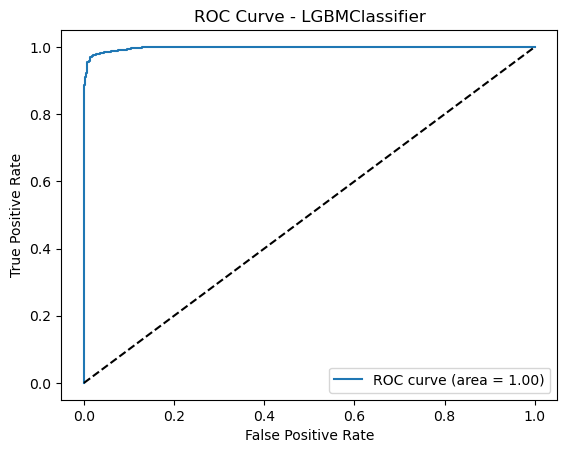

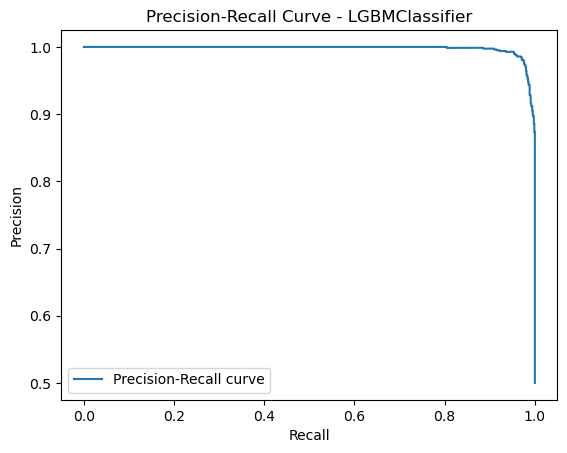


Explicando LGBMClassifier com SHAP...
SHAP explanation failed for LGBMClassifier: TreeExplainer.__init__() got an unexpected keyword argument 'check_additivity'

Avaliação Detalhada para LGBMClassifier:
Melhores Parâmetros: {'learning_rate': 0.05679835610086079, 'max_depth': 5, 'n_estimators': 137, 'num_leaves': 40}
Cross-Val F1 Mean: 0.9714 ± 0.0063
Acurácia de Teste: 0.9768
Precisão de Teste: 0.9858
Revocação de Teste: 0.9676
F1 de Teste: 0.9766
Área sob a curva ROC de Teste: 0.9976

Matriz de confusão:
[[851  12]
 [ 28 835]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98       863
        True       0.99      0.97      0.98       863

    accuracy                           0.98      1726
   macro avg       0.98      0.98      0.98      1726
weighted avg       0.98      0.98      0.98      1726


Training MLPClassifier...


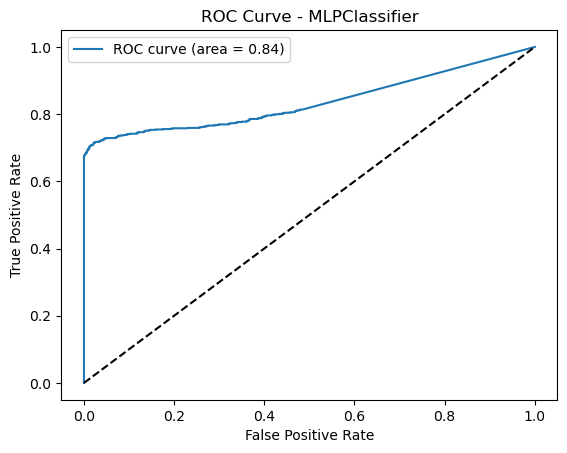

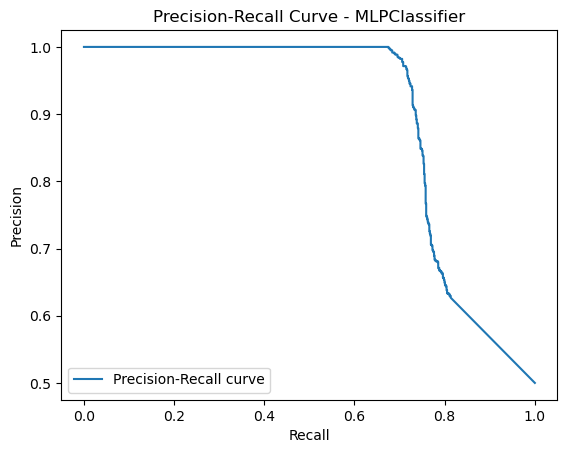


Explicando MLPClassifier com SHAP...
SHAP explanation failed for MLPClassifier: The passed model is not callable and cannot be analyzed directly with the given masker! Model: MLPClassifier(alpha=0.003062735057040824, hidden_layer_sizes=(100, 100),
              max_iter=1000, random_state=42)

Avaliação Detalhada para MLPClassifier:
Melhores Parâmetros: {'activation': 'relu', 'alpha': 0.003062735057040824, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Cross-Val F1 Mean: 0.8021 ± 0.0612
Acurácia de Teste: 0.7822
Precisão de Teste: 1.0000
Revocação de Teste: 0.5643
F1 de Teste: 0.7215
Área sob a curva ROC de Teste: 0.8364

Matriz de confusão:
[[863   0]
 [376 487]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.70      1.00      0.82       863
        True       1.00      0.56      0.72       863

    accuracy                           0.78      1726
   macro avg       0.85      0.78      0.77  

In [21]:
for name, config in models.items():
    print(f"\nTraining {name}...")
    
    # Usando dados reescalados em modelos que se beneficiam disso
    if name in ['LogisticRegression', 'KNeighborsClassifier', 'SVC']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test
    
    # Hyperparameter optimization com RandomizedSearchCV
    search = RandomizedSearchCV(
        config['model'], 
        config['params'], 
        n_iter=20, 
        cv=5, 
        scoring='f1',
        random_state=42, 
        n_jobs=-1
    )
    search.fit(X_train_use, y_train)

    evaluate_model(search.best_estimator_, X_train_use, y_train, X_test_use, X, search.best_params_)

# Explorando relações entre coeficientes do SVM

In [66]:
svc_small.intercept_

array([3.01168817])

In [57]:
svc_small.coef_

array([[-16.57177573,  -7.93103569,  -7.21790617,  -6.13894562,
         -6.31471621,   6.89082209,   6.64504696,  -5.76570933,
          6.00467983,   5.50399147,   5.50399147,  -3.14595898,
          4.71213299,   6.03972513,  -4.75758272,   0.5836873 ]])

                  feature       coef   abs_coef
1            Qui Quadrado -17.459598  17.459598
6                  RS R-s  -8.894206   8.894206
20            norm RS R-s  -6.728522   6.728522
17             norm RS Rm  -6.600373   6.600373
13                  Media  -6.438173   6.438173
23  norm RS R-m (1 - p/2)   5.417259   5.417259
9        RS R-m (1 - p/2)   5.315233   5.315233
18             norm RS Sm   5.057596   5.057596
21   norm RS Rm (1 - p/2)  -4.892915   4.892915
5                  RS R-m   4.823191   4.823191
24  norm RS R-s (1 - p/2)   4.518307   4.518307
0                 Tamanho   3.383916   3.383916
2                RS Total   3.383916   3.383916
14              Variancia  -3.370220   3.370220
3                   RS Rm   2.774307   2.774307
8         RS Sm (1 - p/2)  -2.751715   2.751715
7         RS Rm (1 - p/2)   2.641856   2.641856
11                   RS x  -2.194410   2.194410
4                   RS Sm   2.138269   2.138269
22   norm RS Sm (1 - p/2)   2.059319   2

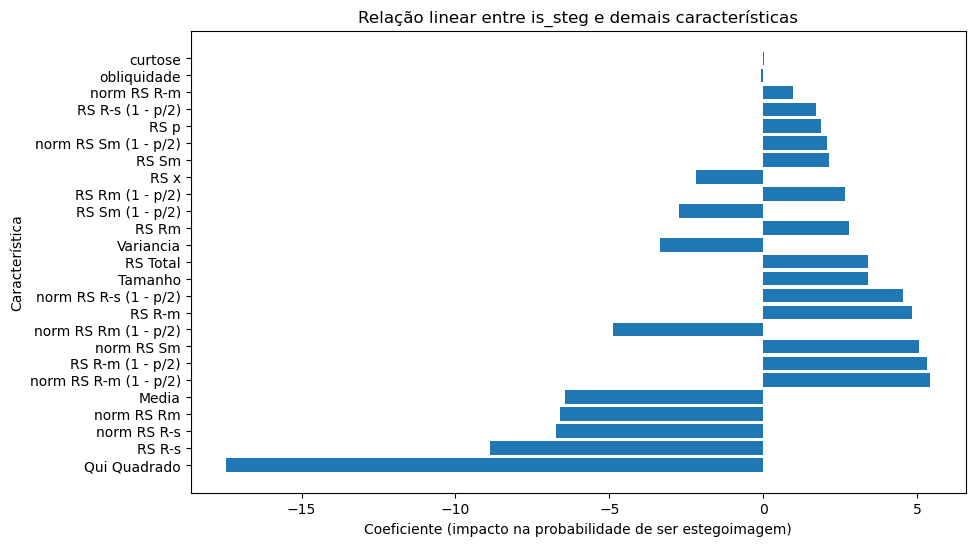

In [22]:
svc_ex = SVC(C=9.485527090157502, gamma=0.0017787658410143284, kernel='linear', probability=True)  # Dos melhores parâmetros
svc_ex.fit(X_train_scaled, y_train)

coefs = svc_ex.coef_[0]
features = X.columns

coef_df = pd.DataFrame({"feature": features, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

print(coef_df)

# Plot
plt.figure(figsize=(10,6))
plt.barh(coef_df["feature"], coef_df["coef"])
plt.xlabel("Coeficiente (impacto na probabilidade de ser estegoimagem)")
plt.ylabel("Característica")
plt.title("Relação linear entre is_steg e demais características")
plt.show()


# Testando SVM com seleção de features

In [29]:
X_small = X[[
 'Qui Quadrado',
 'RS R-s',
 'norm RS R-s',
 'norm RS Rm',
 'Media',
 'norm RS R-m (1 - p/2)',
 #'RS R-m (1 - p/2)',
 'norm RS Sm',
 'norm RS Rm (1 - p/2)',
 #'RS R-m',
 'norm RS R-s (1 - p/2)',
 'Tamanho',
 'RS Total',
 'Variancia',
 'RS Rm',
 #'RS Sm (1 - p/2)',
 'RS Rm (1 - p/2)',
 'RS x',
 #'RS Sm',
 #'norm RS Sm (1 - p/2)',
 #'RS p',
 #'RS R-s (1 - p/2)',
 'norm RS R-m',
 #'obliquidade',
 #'curtose'
]]

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y, test_size=0.2, random_state=42, stratify=y)

X_train_small = scaler.fit_transform(X_train_small)
X_test_small = scaler.transform(X_test_small)


svc_small = SVC(C=9.485527090157502, gamma=0.0017787658410143284, kernel='linear', probability=True)
svc_small.fit(X_train_small, y_train_small)
y_pred_svc = svc_small.predict(X_test_small)
print(f"SVC com seleção de features: F1={f1_score(y_test_small, y_pred_svc):.4f}, Acc={accuracy_score(y_test_small, y_pred_svc):.4f}")

SVC com seleção de features: F1=0.9925, Acc=0.9925


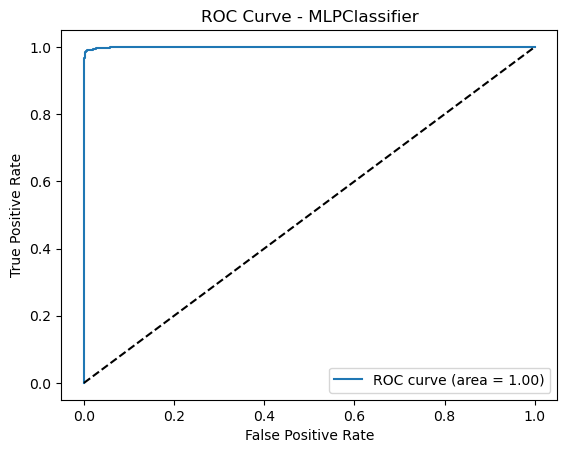

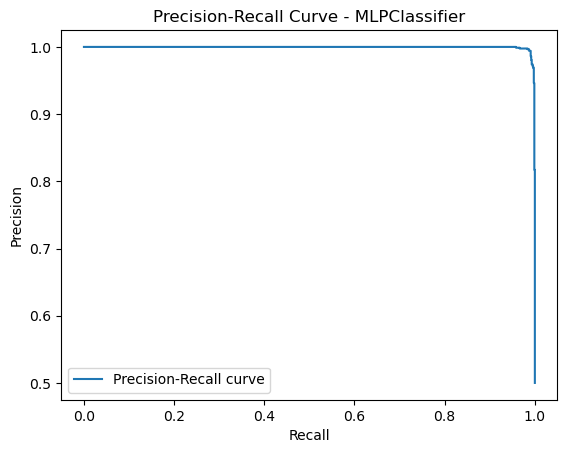


Explicando MLPClassifier com SHAP...


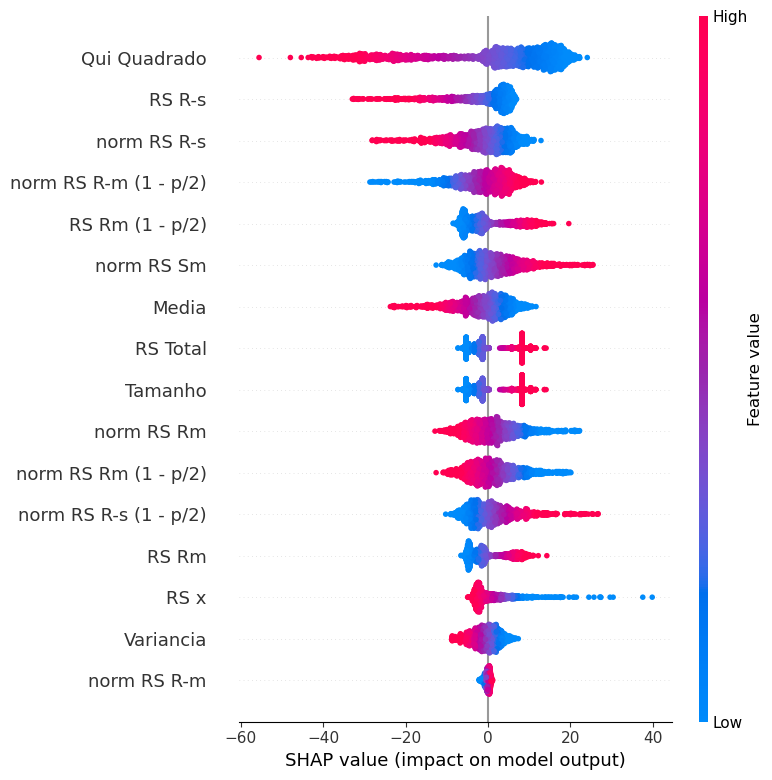


Feature Importances for MLPClassifier (SHAP):
Qui Quadrado             13.668699
RS R-s                    5.639818
norm RS R-s               5.347773
norm RS R-m (1 - p/2)     5.167608
RS Rm (1 - p/2)           5.068341
norm RS Sm                4.997787
Media                     4.731275
Tamanho                   4.728302
RS Total                  4.728302
norm RS Rm                4.722230
norm RS Rm (1 - p/2)      4.393599
norm RS R-s (1 - p/2)     4.369733
RS Rm                     4.019357
RS x                      3.183125
Variancia                 2.496119
norm RS R-m               0.441293
dtype: float64

Avaliação Detalhada para MLPClassifier:
Cross-Val F1 Mean: 0.9833 ± 0.0039
Acurácia de Teste: 0.9925
Precisão de Teste: 0.9942
Revocação de Teste: 0.9907
F1 de Teste: 0.9925
Área sob a curva ROC de Teste: 0.9994

Matriz de confusão:
[[858   5]
 [  8 855]]

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.99      0.99    

In [28]:
evaluate_model(svc_small, X_train_small, y_train_small, X_test_small, X_small)